# ED-IP Prediction with Random Forests

The goal of the model is to predict whether or not a member is going to have an ED or IP visit in the next 180 following the latest claim stratification. 

In [26]:
# Importing Necessary dependencies
import pandas as pd
import snowflake.connector as sf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time
import os

In [27]:
# Snowflake credentials stored in environment variables

username = os.getenv('Snowflake_User')
password = os.getenv('Snowflake_password')
account = os.getenv('Snowflake_account')

# Define warehouse, if necessary
warehouse = 'DEVELOPER_BASIC'

# Define Database, if not defined in SQL request
#database = 'VESTA_STAGING'

# Create connection object for Snowflake connection
conn = sf.connect(user = username, password = password, account = account, warehouse = warehouse)

# Execution function
def execute_query(connection,query):
    cursor = connection.cursor()
    cursor.execute(query)
    cursor.close

try:
    # If defining a database, uncomment code set and add database in connection parameter
    #sql = 'use {}'.format(database)
    #execute_query(conn,sql)
    
    # Define warehouse to use in Snowflake
    sql = 'use warehouse {}'.format(warehouse)
    execute_query(conn,sql)
    
    print('Successful Connection')
    
    # Query to Snowflake
    sql = '''WITH EDIP AS ( //This is sub table for a self join

    SELECT 
        *
    FROM "VESTA_DEVELOPMENT"."CLAIMS_REPORTING"."CTL_MEM_PROFILE_IP_ER_SNF" //THIS NEEDS TO CHANGE BASED ON CLIENT
    WHERE MEASURE = 'ED' or MEASURE = 'IP' 

    ),

    EDIPTABLE AS ( //This table shows the Member ID, date start, and the number of ED/IP in the next 6 months

    SELECT
        SCORE.MEMBER_ID,
        TO_DATE(CONCAT(LEFT(SCORE.DATA_DATE_START,4),'-',RIGHT(SCORE.DATA_DATE_START,2),'-01')) AS DATE_START,
        COUNT(DISTINCT EDIP.DOS_FROM) AS ED_IP_VISITS_IN_NEXT_6_MONTHS
    FROM "VESTA_DEVELOPMENT"."ANALYST_SANDBOX"."CLNT_STRAT_VIP" SCORE
        LEFT JOIN EDIP 
            ON SCORE.MEMBER_ID = EDIP.MEMBER_ID
                AND EDIP.DOS_FROM > TO_DATE(CONCAT(LEFT(SCORE.DATA_DATE_START,4),'-',RIGHT(SCORE.DATA_DATE_START,2),'-01'))
                AND DATEDIFF(days,TO_DATE(CONCAT(LEFT(SCORE.DATA_DATE_START,4),'-',RIGHT(SCORE.DATA_DATE_START,2),'-01')),EDIP.DOS_FROM) >= 45
                AND DATEDIFF(days, TO_DATE(CONCAT(LEFT(SCORE.DATA_DATE_START,4),'-',RIGHT(SCORE.DATA_DATE_START,2),'-01')),EDIP.DOS_FROM) <= 180
    GROUP BY SCORE.MEMBER_ID,
        DATE_START 

    )

SELECT
    //TO_DATE(CONCAT(LEFT(SCORE.DATA_DATE_START,4),'-',RIGHT(SCORE.DATA_DATE_START,2),'-01')) AS DATE_START,
    //DATA_DATE_START,
    //SCORE.MEMBER_ID,
    CASE WHEN EDIPTABLE.ED_IP_VISITS_IN_NEXT_6_MONTHS > 0 THEN 1 ELSE 0 END as ED_IP_VISIT,
    ACSC__COUNT,
    ACSC__SCORE,
    ACSC_A_FIB_AND_FLUTTER,
    ACSC_ALCOHOL_RELATED,
    ACSC_ANEMIA,
    ACSC_ANGINA,
    ACSC_ASTHMA,
    ACSC_CELLULITIS,
    ACSC_CONGESTIVE_HEART_FAILURE,
    ACSC_CONSTIPATION,
    ACSC_CONVULSION_EPILEPSY,
    ACSC_COPD,
    ACSC_DECUBITI_STAGE_3_,
    ACSC_DEHYDRATION_GASTROENTERITIS,
    ACSC_DIABETES_COMPLICATIONS,
    ACSC_DYSPEPSIA,
    ACSC_ENT_INFECTION,
    ACSC_HYPERTENSION,
    ACSC_HYPOGLYCEMIA,
    ACSC_HYPOKALEMIA,
    ACSC_INFLUENZA_PNEUMONIA,
    ACSC_MIGRAINE_HEADACHE,
    ACSC_NUTRITION_DEFICIENT,
    ACSC_PERFORATED_BLEEDING_ULCER,
    ACSC_PROXIMAL_FEMUR_FRACTURE,
    ACSC_PYELONEPHRITIS,
    ACSC_UTI,
    ACSC_VACCINE_PREVENTABLE_DX,
    DATEDIFF(year,DOB, TO_DATE(CONCAT(LEFT(SCORE.DATA_DATE_START,4),'-',RIGHT(SCORE.DATA_DATE_START,2),'-01'))) as AGE,
    AMB_ACSC_COST,
    AMB_ACSC_COUNT,
    BH__COUNT,
    BH__SCORE,
    BH_ALTERED_MENTAL_STATE,
    BH_ALZHEIMERS_DEMENTIA,
    BH_ANXIETY,
    BH_BI_POLAR,
    BH_DEPRESSION,
    BH_SCHIZOPHRENIA,
    BH_SUBABUSE,
    CRN__COUNT,
    CRN_AFIB,
    CRN_ASTHMA,
    CRN_CARDIOVASCULAR_DX,
    CRN_CHRONIC_KIDNEY_DISEASE,
    CRN_CONGESTIVE_HEART_FAILURE,
    CRN_COPD,
    CRN_DIABETES_W__ACUTE_COMP,
    CRN_DIABETES_W__CHRONIC_COMP,
    CRN_DIABETES_W_OUT_COMP,
    CRN_FALLS,
    CRN_GASTRO_ESOPH_REFLUX,
    CRN_HIP_FRACTURE,
    CRN_HTN,
    CRN_OBESITY,
    CRN_OSTEOPOROSIS,
    CRN_PARKINSONS_DISEASE,
    CRN_PRESSURE_ULCER,
    CRN_PRIOR_MI,
    CRN_PRIOR_STROKE,
    CRN_SCORE,
    CRN_SLEEP_APNEA,
    CRN_SMOKING,
    CRN_UTI,
    DYAD_CKD_DD,
    DYAD_CKD_OP,
    DYAD_COPD_DD,
    DYAD_COPD_HF,
    DYAD_COPD_OP,
    DYAD_COUNT,
    DYAD_DM_CKD,
    DYAD_DM_OP,
    DYAD_HBP_HF,
    DYAD_HF_CKD,
    ED_ACSC_COST,
    ED_ACSC_COUNT,
    GENDER,
    CASE WHEN "GROUP" = 'E' THEN 'A' ELSE "GROUP" END as "GROUP",
    HMKR_ACSC_COST,
    HMKR_ACSC_COUNT,
    HTI_RISK_SCORE_V2_1,
    IP_ACSC_COST,
    IP_ACSC_COUNT,
    IP_READMIT_ACSC_COST,
    IP_READMIT_ACSC_COUNT,
    IP_RHB_ACSC_COST,
    IP_RHB_ACSC_COUNT,
    CASE WHEN LANGUAGE_SPOKEN is NULL THEN 'Unknown'
         WHEN LANGUAGE_SPOKEN = 'English' THEN 'English'
         WHEN LANGUAGE_SPOKEN = 'Chinese' THEN 'Chinese'
         WHEN LANGUAGE_SPOKEN = 'Spanish' THEN 'Spanish'
         WHEN LANGUAGE_SPOKEN = 'Russian' THEN 'Russian'
    ELSE 'Other' END AS LANGUAGE_SPOKEN_CLEAN,
    NI_COST_DENT,
    NI_COST_ED,
    NI_COST_HM,
    NI_COST_HMKR,
    NI_COST_HS,
    NI_COST_IP,
    NI_COST_IP_RHB,
    NI_COST_OP,
    NI_COST_OTH,
    NI_COST_PCA_T1020,
    NI_COST_PCA_T1019,
    NI_COST_PR,
    NI_COST_PSYC,
    NI_COST_RX,
    NI_COUNT_DENT,
    NI_COUNT_ED,
    NI_COUNT_HM,
    NI_COUNT_HMKR,
    NI_COUNT_HS,
    NI_COUNT_IP,
    NI_COUNT_IP_RHB,
    NI_COUNT_OP,
    NI_COUNT_OTH,
    NI_COUNT_PCA_T1020,
    NI_COUNT_PCA_T1019,
    NI_COUNT_PR,
    NI_COUNT_PSYC,
    NI_COUNT_RX,
    NON_IMPACTABLE_CLAIM_COUNT,
    OP_ACSC_COST,
    OP_ACSC_COUNT,
    CAST(PART_C_RISK_SCORE as FLOAT) as PART_C_RISK_SCORE,
    PCA_T1020_ACSC_COUNT,
    PCA_T1020_ACSC_COST,
    PCA_T1019_ACSC_COUNT,
    PCA_T1019_ACSC_COST,
    PR_ACSC_COST,
    PR_ACSC_COUNT,
    //CASE WHEN RC is NULL THEN 'UNDEFINED' ELSE RC END AS RC_CLEAN,
    SNF_COST,
    SNF_COUNT,
    TOTAL_IMPACTABLE_COST,
    TOTAL_IMPACTABLE_COST_PRO,
    TOTAL_NON_IMPACTABLE_COST
FROM "VESTA_DEVELOPMENT"."ANALYST_SANDBOX"."CLNT_STRAT_VIP" SCORE
    LEFT JOIN EDIPTABLE
        ON SCORE.MEMBER_ID = EDIPTABLE.MEMBER_ID
            AND TO_DATE(CONCAT(LEFT(SCORE.DATA_DATE_START,4),'-',RIGHT(SCORE.DATA_DATE_START,2),'-01')) = EDIPTABLE.DATE_START
WHERE SCORE.CLNT = 'CTL' //THIS NEEDS TO CHANGE BASED ON CLIENT
    AND TO_DATE(CONCAT(LEFT(SCORE.DATA_DATE_START,4),'-',RIGHT(SCORE.DATA_DATE_START,2),'-01')) 
     between '2020-04-01' and TO_DATE(CONCAT(LEFT(CURRENT_DATE-210,7),'-01')) //This is looking at files that have had a reasonable amount of time to process'''

    cursor = conn.cursor()
    cursor.execute(sql)
    
    # Dataframe creation
    df = pd.DataFrame.from_records(iter(cursor), columns = [x[0] for x in cursor.description])
    
    print('Successful DataFrame Created')
    
    cursor.close
    
except Exception as e:
        print(e)
        
finally:
    conn.close
    
print('Ready for Cleaning')

Successful Connection
Successful DataFrame Created
Ready for Cleaning


In [28]:
df.head()

,ED_IP_VISIT,ACSC__COUNT,ACSC__SCORE,ACSC_A_FIB_AND_FLUTTER,ACSC_ALCOHOL_RELATED,ACSC_ANEMIA,ACSC_ANGINA,ACSC_ASTHMA,ACSC_CELLULITIS,ACSC_CONGESTIVE_HEART_FAILURE,...,PCA_T1020_ACSC_COST,PCA_T1019_ACSC_COUNT,PCA_T1019_ACSC_COST,PR_ACSC_COST,PR_ACSC_COUNT,SNF_COST,SNF_COUNT,TOTAL_IMPACTABLE_COST,TOTAL_IMPACTABLE_COST_PRO,TOTAL_NON_IMPACTABLE_COST
0,0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,...,0.0,10.0,9534.82,0.00,0.0,0.0,0.0,26883.41,26883.41,19076.48
1,0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,...,0.0,21.0,5785.00,0.00,0.0,0.0,0.0,7689.83,7689.83,24740.59
2,0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,...,0.0,12.0,5947.69,162.09,1.0,0.0,0.0,31127.85,31127.85,14279.79
3,0,4.0,2.0,0.0,0.0,0.0,1.0,0.0,NaN,1.0,...,0.0,14.0,9377.28,217.71,3.0,0.0,0.0,27610.09,27610.09,12238.78
4,0,4.0,2.0,0.0,0.0,0.0,0.0,1.0,NaN,0.0,...,0.0,14.0,1349.88,88.64,5.0,0.0,0.0,11718.65,11718.65,3816.77


### Cleaning Operations

In [5]:
# Find features with missing values
sumdf = pd.DataFrame(df.isna().sum())

features_to_drop = []
for row in sumdf.iterrows():
    if row[1][0] != 0:
        features_to_drop.append(row[0])

# Review features with missing values
print('These are the features that initially had missing values within the data frame: \n',features_to_drop,'\n\n')

Nulls_to_correct = ['ACSC_ALCOHOL_RELATED',
                    'ACSC_CELLULITIS',
                    'ACSC_ENT_INFECTION',
                    'ACSC_HYPOGLYCEMIA',
                    'ACSC_MIGRAINE_HEADACHE',
                    'ACSC_VACCINE_PREVENTABLE_DX',
                    'BH_SUBABUSE',
                    'CRN_SMOKING', 
                    'NI_COST_DENT',
                    'NI_COST_HMKR',
                    'NI_COST_HS',
                    'NI_COST_IP_RHB',
                    'NI_COST_PSYC',
                    'NI_COUNT_DENT',
                    'NI_COUNT_HMKR',
                    'NI_COUNT_HS',
                    'NI_COUNT_IP_RHB',
                    'NI_COUNT_PSYC'] 

# Fill selected features with 0 value
for col in Nulls_to_correct:
    df[col] = df[col].fillna(0)
    
# Check for missing values and drop columns with missing values
sumdf = pd.DataFrame(df.isna().sum())

features_to_drop = []
for row in sumdf.iterrows():
    if row[1][0] != 0:
        features_to_drop.append(row[0])

print('These columns were dropped after because missing values were not corrected :\n', features_to_drop,'\n\n')        
df = df.drop(columns = features_to_drop)

# Convert object datatypes to dummy variables
object_list = []

for col in df.columns:
    if df[col].dtypes == 'object':
        object_list.append(col)
        
print('These are the features that were converted to dummy variables: \n',object_list,'\n\n')
df = pd.get_dummies(df, columns = object_list, drop_first = True)

df.head(20)

These are the features that initially had missing values within the data frame: 
 [] 


These columns were dropped after because missing values were not corrected :
 [] 


These are the features that were converted to dummy variables: 
 [] 




,ED_IP_VISIT,ACSC__COUNT,ACSC__SCORE,ACSC_A_FIB_AND_FLUTTER,ACSC_ALCOHOL_RELATED,ACSC_ANEMIA,ACSC_ANGINA,ACSC_ASTHMA,ACSC_CELLULITIS,ACSC_CONGESTIVE_HEART_FAILURE,...,TOTAL_IMPACTABLE_COST,TOTAL_IMPACTABLE_COST_PRO,TOTAL_NON_IMPACTABLE_COST,GENDER_M,GROUP_C,GROUP_D,LANGUAGE_SPOKEN_CLEAN_English,LANGUAGE_SPOKEN_CLEAN_Other,LANGUAGE_SPOKEN_CLEAN_Russian,LANGUAGE_SPOKEN_CLEAN_Spanish
0,0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,26883.41,26883.41,19076.480000,1,0,0,1,0,0,0
1,0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7689.83,7689.83,24740.590000,0,0,0,1,0,0,0
2,0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,31127.85,31127.85,14279.790000,0,0,0,1,0,0,0
3,0,4.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,27610.09,27610.09,12238.780000,0,0,0,1,0,0,0
4,0,4.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,11718.65,11718.65,3816.770000,0,0,0,1,0,0,0
5,0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,5446.04,5446.04,7858.640000,1,0,0,1,0,0,0
6,0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,50418.41,50418.41,24123.410000,0,0,0,0,0,0,1
7,0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,125594.68,125594.68,22369.569999,0,0,0,1,0,0,0
8,0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,19047.62,19047.62,22988.260000,0,0,0,1,0,0,0
9,0,2.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,31836.46,31836.46,14850.400000,0,0,0,1,0,0,0


In [4]:
#convert data types
#changing all float64 to float32

original_memory = df.memory_usage().sum()
print(f'Memory Usage of Dataframe: {df.memory_usage().sum()} bytes')
df[df.select_dtypes(np.float64).columns] = df.select_dtypes(np.float64).astype(np.float32)

# df = df.astype('float32')
#
# df.head()
df.info()

new_memory = df.memory_usage().sum()
print(f'Memory Usage of Original Dataframe: {original_memory} bytes')
print(f'Memory Usage of New Dataframe: {new_memory} bytes')
print(f'Memory usage reduced by:{round((original_memory - new_memory) / original_memory * 100, 0)}%')

Memory Usage of Dataframe: 47063711 bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45297 entries, 0 to 45296
Columns: 136 entries, ED_IP_VISIT to LANGUAGE_SPOKEN_CLEAN_Spanish
dtypes: float32(121), int64(8), uint8(7)
memory usage: 24.0 MB
Memory Usage of Original Dataframe: 47063711 bytes
Memory Usage of New Dataframe: 25139963 bytes
Memory usage reduced by:47.0%


### Option to remove low variability features

This block is here to run as optional pre-processing. 

In [9]:
# Drop low variability columns
df_var = df.var()
df.columns.to_list()

features_to_drop = []

for i in range(len(df.columns.to_list())):
    #print(df.columns.to_list()[i],df_var[i])
    if df_var[i] == 0 and df.columns.to_list()[i] != 'ED_IP_VISIT':
        features_to_drop.append(df.columns.to_list()[i])

        
print('These are the features that were dropped because of low variability: \n',features_to_drop,'\n\n')
        
df = df.drop(columns = features_to_drop)
df.head(20)

These are the features that were dropped because of low variability: 
 [] 




,ED_IP_VISIT,ACSC__COUNT,ACSC__SCORE,ACSC_A_FIB_AND_FLUTTER,ACSC_ALCOHOL_RELATED,ACSC_ANEMIA,ACSC_ANGINA,ACSC_ASTHMA,ACSC_CELLULITIS,ACSC_CONGESTIVE_HEART_FAILURE,...,TOTAL_IMPACTABLE_COST,TOTAL_IMPACTABLE_COST_PRO,TOTAL_NON_IMPACTABLE_COST,GENDER_M,GROUP_C,GROUP_D,LANGUAGE_SPOKEN_CLEAN_English,LANGUAGE_SPOKEN_CLEAN_Other,LANGUAGE_SPOKEN_CLEAN_Russian,LANGUAGE_SPOKEN_CLEAN_Spanish
0,0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,26883.41,26883.41,19076.480000,1,0,0,1,0,0,0
1,0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7689.83,7689.83,24740.590000,0,0,0,1,0,0,0
2,0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,31127.85,31127.85,14279.790000,0,0,0,1,0,0,0
3,0,4.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,27610.09,27610.09,12238.780000,0,0,0,1,0,0,0
4,0,4.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,11718.65,11718.65,3816.770000,0,0,0,1,0,0,0
5,0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,5446.04,5446.04,7858.640000,1,0,0,1,0,0,0
6,0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,50418.41,50418.41,24123.410000,0,0,0,0,0,0,1
7,0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,125594.68,125594.68,22369.569999,0,0,0,1,0,0,0
8,0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,19047.62,19047.62,22988.260000,0,0,0,1,0,0,0
9,0,2.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,31836.46,31836.46,14850.400000,0,0,0,1,0,0,0


### Spliting, Scaling, and SMOTE (Synthetic Minority Oversampling Technique)

In [10]:
# Split the data set
X = df[[col for col in df.columns if col != 'ED_IP_VISIT']] #independent variables
y = df[[col for col in df.columns if col == 'ED_IP_VISIT']] #dependent variable
y = y.values.flatten()

# Define MinMax Scaler
scaler = MinMaxScaler()

# Transform data
X = scaler.fit_transform(X)

# Split X and y into training and testing sets
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.30, random_state = 2)

# Smote for balancing the training data set
smote = SMOTE(random_state = 2)
X_train,y_train = smote.fit_resample(X_train, y_train)

In [21]:
y
# y_train


array([0, 0, 0, ..., 0, 1, 1], dtype=int64)

### Creating and Training Random Forest Classifier

In [22]:
%%time
# Create a Random Forest Classifier
clf=RandomForestClassifier(n_estimators = 2000,min_samples_split = 2, min_samples_leaf = 1,
                           max_depth = 50, bootstrap = False, n_jobs = -1,random_state = 2)

# Train the model using the training sets
clf.fit(X_train,y_train)

CPU times: total: 21min 22s
Wall time: 1min 26s


RandomForestClassifier(bootstrap=False, max_depth=50, n_estimators=2000,
                       n_jobs=-1, random_state=2)

### Reporting on Performace

In [23]:
# Create probabilities from the model on test data
y_prob = clf.predict_proba(X_test)[:,1]

# Store probabilites in Datafram for threshold analysis
threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
accuracy_list = []
precision_list = []
recall_list = []
for threshold in threshold_list:
    y_pred = [1 if result >= threshold else 0 for result in y_prob]
   
    #Calulating Metrics
    accuracy = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)
    
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    
    #print('Thereshold: ',threshold)
    #print("Accuracy: ",accuracy)
    #print("Precision: ",precision)
    #print("Recall: ",recall)
    
metric_df = pd.DataFrame()
metric_df['Threshold'] = threshold_list
metric_df['Accuracy'] = accuracy_list
metric_df['Precision'] = precision_list
metric_df['Recall'] = recall_list
metric_df['F1'] = (2 * metric_df['Precision'] * metric_df['Recall']) / (metric_df['Precision'] + metric_df['Recall'])
metric_df['Acc + Recall'] = metric_df['Accuracy'] + metric_df['Recall']

metric_df

,Threshold,Accuracy,Precision,Recall,F1,Acc + Recall
0,0.05,0.279441,0.167618,0.992958,0.286819,1.272399
1,0.10,0.479893,0.214808,0.965728,0.351444,1.445621
2,0.15,0.635473,0.275818,0.921596,0.424570,1.557069
3,0.20,0.749949,0.355403,0.876995,0.505822,1.626944
4,0.25,0.822018,0.440579,0.814554,0.571852,1.636572
5,0.30,0.866753,0.530803,0.748357,0.621079,1.615110
6,0.35,0.890594,0.611553,0.685915,0.646603,1.576509
7,0.40,0.902651,0.684539,0.617371,0.649222,1.520022
8,0.45,0.905666,0.742747,0.540845,0.625917,1.446511
9,0.50,0.905529,0.793130,0.476995,0.595720,1.382524


### Confusion Matrix for Threshold with Max Accuracy + Recall

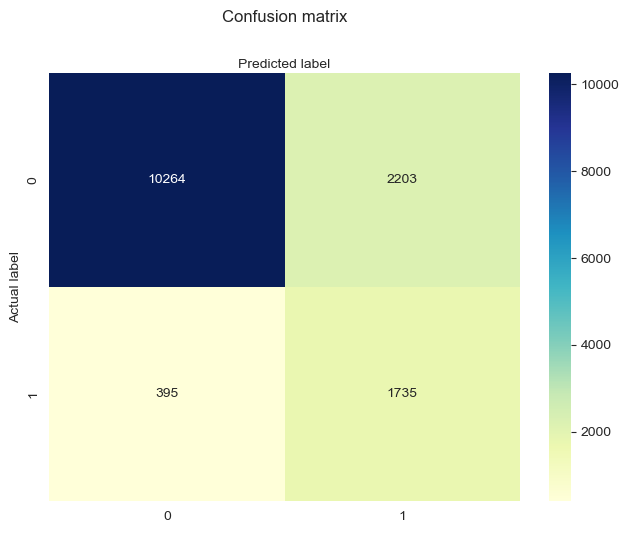

Thereshold:  0.25
Accuracy:  0.8220182229225184
Precision:  0.4405789740985272
Recall:  0.8145539906103286
F1:  0.5718523401450231


In [24]:
#Find the max accuracy and recall from the Metric Table and corresponding Threshold
threshold = metric_df[metric_df['Acc + Recall'] == metric_df['Acc + Recall'].max()]['Threshold'].item()

y_pred = [1 if result >= threshold else 0 for result in y_prob]


# Creating confusion maxtrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

%matplotlib inline
class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")

# Axis labels
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# Show the plot
plt.show()


#Calulating Metrics
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
    
print('Thereshold: ',threshold)
print("Accuracy: ",accuracy)
print("Precision: ",precision)
print("Recall: ",recall)
print('F1: ', (2*precision*recall)/(precision+recall))

### ROC and AUC and Precision-Recall Curve

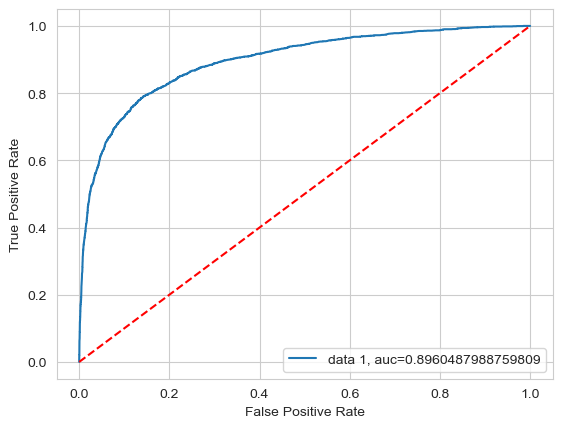

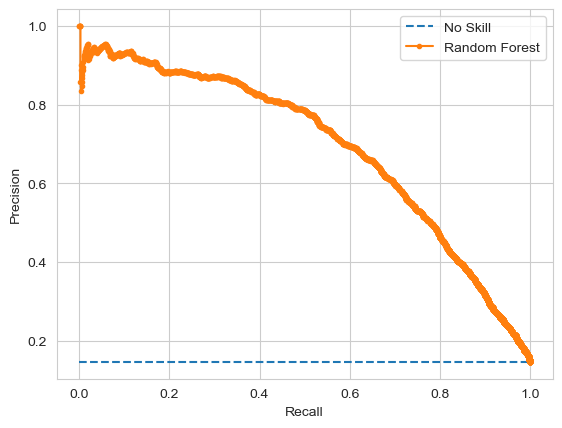

In [25]:
fpr, tpr, thresholds = metrics.roc_curve(y_test,  y_prob)

# Print(thresholds)
auc = metrics.roc_auc_score(y_test, y_prob)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.plot([0, 1], [0, 1], color="red", linestyle="--")

# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

# Show the legend
plt.legend(loc=4)

# Show the plot
plt.show()

# Calculate precision and recall for each threshold
precision, recall, _ = metrics.precision_recall_curve(y_test, y_prob)

# Calculate scores
f1, auc = metrics.f1_score(y_test, y_pred), metrics.auc(recall, precision)

# Plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Random Forest')

# Axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')

# Show the legend
plt.legend()

# Show the plot
plt.show()

### Ensemble of Random Forests

In [6]:
forest_dict = {}

for i in range(0,10):
    start_time = time.time()
    # Split the data set
    X = df[[col for col in df.columns if col != 'ED_IP_VISIT']] #independent variables
    y = df[[col for col in df.columns if col == 'ED_IP_VISIT']] #dependent variable
    y = y.values.flatten()

    # Define MinMax Scaler
    scaler = MinMaxScaler()

    # Transform data
    X = scaler.fit_transform(X)

    # Split X and y into training and testing sets
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.30, random_state = i)

    # Smote for balancing the training data set
    smote = SMOTE(random_state = i)
    X_train,y_train = smote.fit_resample(X_train, y_train)
    
    # Create a Random Forest Classifier
    clf=RandomForestClassifier(n_estimators = 2000,min_samples_split = 2, min_samples_leaf = 1,
                           max_depth = 50, bootstrap = False, n_jobs = -1,random_state = i)

    # Train the model using the training sets
    clf.fit(X_train,y_train)
    
    #Store Random Forest
    forest_dict[i] = clf
    
    print( "--- %s seconds ---" % (time.time() - start_time))
    

--- 84.99997997283936 seconds ---
--- 86.25003838539124 seconds ---
--- 88.54207634925842 seconds ---
--- 129.10156512260437 seconds ---
--- 150.8222692012787 seconds ---
--- 138.54971146583557 seconds ---
--- 170.28341221809387 seconds ---
--- 145.02509689331055 seconds ---
--- 183.0761570930481 seconds ---
--- 132.13322591781616 seconds ---


### New Query for Prediction

In [7]:
# Snowflake credentials stored in environment variables

username = os.getenv('Snowflake_User')
password = os.getenv('Snowflake_password')
account = os.getenv('Snowflake_account')

# Define warehouse, if necessary
warehouse = 'DEVELOPER_BASIC'

# Define Database, if not defined in SQL request
#database = 'VESTA_STAGING'

# Create connection object for Snowflake connection
conn = sf.connect(user = username, password = password, account = account, warehouse = warehouse)

# Execution function
def execute_query(connection,query):
    cursor = connection.cursor()
    cursor.execute(query)
    cursor.close

try:
    # If defining a database, uncomment code set and add database in connection parameter
    #sql = 'use {}'.format(database)
    #execute_query(conn,sql)
    
    # Define warehouse to use in Snowflake
    sql = 'use warehouse {}'.format(warehouse)
    execute_query(conn,sql)
    
    print('Successful Connection')
    
    # Query to Snowflake
    sql = '''
WITH EDIP AS ( //This is sub table for a self join

    SELECT 
        *
    FROM "VESTA_DEVELOPMENT"."CLAIMS_REPORTING"."CTL_MEM_PROFILE_IP_ER_SNF" //THIS NEEDS TO CHANGE BASED ON CLIENT
    WHERE MEASURE = 'ED' or MEASURE = 'IP' 

    ),

EDIPTABLE AS ( //This table shows the Member ID, date start, and the number of ED/IP in the next 6 months

    SELECT
        SCORE.MEMBER_ID,
        TO_DATE(CONCAT(LEFT(SCORE.DATA_DATE_START,4),'-',RIGHT(SCORE.DATA_DATE_START,2),'-01')) AS DATE_START,
        COUNT(DISTINCT EDIP.DOS_FROM) AS ED_IP_VISITS_IN_NEXT_6_MONTHS
    FROM "VESTA_DEVELOPMENT"."ANALYST_SANDBOX"."CLNT_STRAT_VIP" SCORE
        LEFT JOIN EDIP 
            ON SCORE.MEMBER_ID = EDIP.MEMBER_ID
                AND EDIP.DOS_FROM > TO_DATE(CONCAT(LEFT(SCORE.DATA_DATE_START,4),'-',RIGHT(SCORE.DATA_DATE_START,2),'-01'))
                AND DATEDIFF(days,TO_DATE(CONCAT(LEFT(SCORE.DATA_DATE_START,4),'-',RIGHT(SCORE.DATA_DATE_START,2),'-01')),EDIP.DOS_FROM) >= 45
                AND DATEDIFF(days, TO_DATE(CONCAT(LEFT(SCORE.DATA_DATE_START,4),'-',RIGHT(SCORE.DATA_DATE_START,2),'-01')),EDIP.DOS_FROM) <= 180
    GROUP BY SCORE.MEMBER_ID,
        DATE_START 

    )

SELECT
    //TO_DATE(CONCAT(LEFT(SCORE.DATA_DATE_START,4),'-',RIGHT(SCORE.DATA_DATE_START,2),'-01')) AS DATE_START,
    DATA_DATE_START,
    SCORE.MEMBER_ID,
    CASE WHEN EDIPTABLE.ED_IP_VISITS_IN_NEXT_6_MONTHS > 0 THEN 1 ELSE 0 END as ED_IP_VISIT,
    ACSC__COUNT,
    ACSC__SCORE,
    ACSC_A_FIB_AND_FLUTTER,
    ACSC_ALCOHOL_RELATED,
    ACSC_ANEMIA,
    ACSC_ANGINA,
    ACSC_ASTHMA,
    ACSC_CELLULITIS,
    ACSC_CONGESTIVE_HEART_FAILURE,
    ACSC_CONSTIPATION,
    ACSC_CONVULSION_EPILEPSY,
    ACSC_COPD,
    ACSC_DECUBITI_STAGE_3_,
    ACSC_DEHYDRATION_GASTROENTERITIS,
    ACSC_DIABETES_COMPLICATIONS,
    ACSC_DYSPEPSIA,
    ACSC_ENT_INFECTION,
    ACSC_HYPERTENSION,
    ACSC_HYPOGLYCEMIA,
    ACSC_HYPOKALEMIA,
    ACSC_INFLUENZA_PNEUMONIA,
    ACSC_MIGRAINE_HEADACHE,
    ACSC_NUTRITION_DEFICIENT,
    ACSC_PERFORATED_BLEEDING_ULCER,
    ACSC_PROXIMAL_FEMUR_FRACTURE,
    ACSC_PYELONEPHRITIS,
    ACSC_UTI,
    ACSC_VACCINE_PREVENTABLE_DX,
    DATEDIFF(year,DOB, TO_DATE(CONCAT(LEFT(SCORE.DATA_DATE_START,4),'-',RIGHT(SCORE.DATA_DATE_START,2),'-01'))) as AGE,
    AMB_ACSC_COST,
    AMB_ACSC_COUNT,
    BH__COUNT,
    BH__SCORE,
    BH_ALTERED_MENTAL_STATE,
    BH_ALZHEIMERS_DEMENTIA,
    BH_ANXIETY,
    BH_BI_POLAR,
    BH_DEPRESSION,
    BH_SCHIZOPHRENIA,
    BH_SUBABUSE,
    CRN__COUNT,
    CRN_AFIB,
    CRN_ASTHMA,
    CRN_CARDIOVASCULAR_DX,
    CRN_CHRONIC_KIDNEY_DISEASE,
    CRN_CONGESTIVE_HEART_FAILURE,
    CRN_COPD,
    CRN_DIABETES_W__ACUTE_COMP,
    CRN_DIABETES_W__CHRONIC_COMP,
    CRN_DIABETES_W_OUT_COMP,
    CRN_FALLS,
    CRN_GASTRO_ESOPH_REFLUX,
    CRN_HIP_FRACTURE,
    CRN_HTN,
    CRN_OBESITY,
    CRN_OSTEOPOROSIS,
    CRN_PARKINSONS_DISEASE,
    CRN_PRESSURE_ULCER,
    CRN_PRIOR_MI,
    CRN_PRIOR_STROKE,
    CRN_SCORE,
    CRN_SLEEP_APNEA,
    CRN_SMOKING,
    CRN_UTI,
    DYAD_CKD_DD,
    DYAD_CKD_OP,
    DYAD_COPD_DD,
    DYAD_COPD_HF,
    DYAD_COPD_OP,
    DYAD_COUNT,
    DYAD_DM_CKD,
    DYAD_DM_OP,
    DYAD_HBP_HF,
    DYAD_HF_CKD,
    ED_ACSC_COST,
    ED_ACSC_COUNT,
    GENDER,
    CASE WHEN "GROUP" = 'E' THEN 'A' ELSE "GROUP" END as "GROUP",
    HMKR_ACSC_COST,
    HMKR_ACSC_COUNT,
    HTI_RISK_SCORE_V2_1,
    IP_ACSC_COST,
    IP_ACSC_COUNT,
    IP_READMIT_ACSC_COST,
    IP_READMIT_ACSC_COUNT,
    IP_RHB_ACSC_COST,
    IP_RHB_ACSC_COUNT,
    CASE WHEN LANGUAGE_SPOKEN is NULL THEN 'Unknown'
         WHEN LANGUAGE_SPOKEN = 'English' THEN 'English'
         WHEN LANGUAGE_SPOKEN = 'Chinese' THEN 'Chinese'
         WHEN LANGUAGE_SPOKEN = 'Spanish' THEN 'Spanish'
         WHEN LANGUAGE_SPOKEN = 'Russian' THEN 'Russian'
    ELSE 'Other' END AS LANGUAGE_SPOKEN_CLEAN,
    NI_COST_DENT,
    NI_COST_ED,
    NI_COST_HM,
    NI_COST_HMKR,
    NI_COST_HS,
    NI_COST_IP,
    NI_COST_IP_RHB,
    NI_COST_OP,
    NI_COST_OTH,
    NI_COST_PCA_T1020,
    NI_COST_PCA_T1019,
    NI_COST_PR,
    NI_COST_PSYC,
    NI_COST_RX,
    NI_COUNT_DENT,
    NI_COUNT_ED,
    NI_COUNT_HM,
    NI_COUNT_HMKR,
    NI_COUNT_HS,
    NI_COUNT_IP,
    NI_COUNT_IP_RHB,
    NI_COUNT_OP,
    NI_COUNT_OTH,
    NI_COUNT_PCA_T1020,
    NI_COUNT_PCA_T1019,
    NI_COUNT_PR,
    NI_COUNT_PSYC,
    NI_COUNT_RX,
    NON_IMPACTABLE_CLAIM_COUNT,
    OP_ACSC_COST,
    OP_ACSC_COUNT,
    CAST(PART_C_RISK_SCORE as FLOAT) as PART_C_RISK_SCORE,
    PCA_T1020_ACSC_COUNT,
    PCA_T1020_ACSC_COST,
    PCA_T1019_ACSC_COUNT,
    PCA_T1019_ACSC_COST,
    PR_ACSC_COST,
    PR_ACSC_COUNT,
    //CASE WHEN RC is NULL THEN 'UNDEFINED' ELSE RC END AS RC_CLEAN,
    SNF_COST,
    SNF_COUNT,
    TOTAL_IMPACTABLE_COST,
    TOTAL_IMPACTABLE_COST_PRO,
    TOTAL_NON_IMPACTABLE_COST
FROM "VESTA_DEVELOPMENT"."ANALYST_SANDBOX"."CLNT_STRAT_VIP" SCORE
    LEFT JOIN EDIPTABLE
        ON SCORE.MEMBER_ID = EDIPTABLE.MEMBER_ID
            AND TO_DATE(CONCAT(LEFT(SCORE.DATA_DATE_START,4),'-',RIGHT(SCORE.DATA_DATE_START,2),'-01')) = EDIPTABLE.DATE_START
WHERE SCORE.CLNT = 'CTL' //THIS NEEDS TO CHANGE BASED ON CLIENT
    AND TO_DATE(CONCAT(LEFT(SCORE.DATA_DATE_START,4),'-',RIGHT(SCORE.DATA_DATE_START,2),'-01')) 
        = (SELECT max(TO_DATE(CONCAT(LEFT(DATA_DATE_START,4),'-',RIGHT(DATA_DATE_START,2),'-01')))
        FROM "VESTA_DEVELOPMENT"."ANALYST_SANDBOX"."CLNT_STRAT_VIP" WHERE CLNT = 'CTL')
        // Most Recent Stratification for Client// THIS NEEDS TO CHANGE BASED ON CLIENT'''
    cursor = conn.cursor()
    cursor.execute(sql)
    
    # Dataframe creation
    test_df = pd.DataFrame.from_records(iter(cursor), columns = [x[0] for x in cursor.description])
    
    print('Successful DataFrame Created')
    
    cursor.close
    
except Exception as e:
        print(e)
        
finally:
    conn.close
    
print('Ready for Cleaning')  

print(test_df.shape)
test_df.head()

Successful Connection
Successful DataFrame Created
Ready for Cleaning
(4959, 134)


,DATA_DATE_START,MEMBER_ID,ED_IP_VISIT,ACSC__COUNT,ACSC__SCORE,ACSC_A_FIB_AND_FLUTTER,ACSC_ALCOHOL_RELATED,ACSC_ANEMIA,ACSC_ANGINA,ACSC_ASTHMA,...,PCA_T1020_ACSC_COST,PCA_T1019_ACSC_COUNT,PCA_T1019_ACSC_COST,PR_ACSC_COST,PR_ACSC_COUNT,SNF_COST,SNF_COUNT,TOTAL_IMPACTABLE_COST,TOTAL_IMPACTABLE_COST_PRO,TOTAL_NON_IMPACTABLE_COST
0,202209,1019645,0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,4677.75,0.00,0.0,0.0,0.0,12028.91,20620.99,6490.599999
1,202209,47346,0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,6.0,1730.88,0.00,0.0,0.0,0.0,7396.92,8069.37,6464.520002
2,202209,1020909,0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.00,0.0,0.0,0.0,7408.38,22225.14,9276.810001
3,202209,64722,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,3428.530005
4,202209,76567,0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,153.88,3.0,0.0,0.0,153.88,153.88,6899.330000


### Cleaning Operations

In [8]:
# Remove Member ID and Data Start Date from Data Frame for prediction
data_date_start_list = test_df['DATA_DATE_START']
test_df = test_df.drop(['DATA_DATE_START'], axis = 1)
member_id_list = test_df['MEMBER_ID']
test_df = test_df.drop(['MEMBER_ID'], axis = 1)

#Remove ED_Visit from Data Frame
y_test_df = test_df['ED_IP_VISIT']
test_df = test_df.drop(['ED_IP_VISIT'], axis = 1)

# Find features with missing values
sumdf = pd.DataFrame(test_df.isna().sum())

features_to_drop = []
for row in sumdf.iterrows():
    if row[1][0] != 0:
        features_to_drop.append(row[0])

# Review features with missing values
print('These are the features that initially had missing values within the data frame: \n',features_to_drop,'\n\n')

Nulls_to_correct = ['ACSC_ALCOHOL_RELATED',
                    'ACSC_CELLULITIS',
                    'ACSC_ENT_INFECTION',
                    'ACSC_HYPOGLYCEMIA',
                    'ACSC_MIGRAINE_HEADACHE',
                    'ACSC_VACCINE_PREVENTABLE_DX',
                    'BH_SUBABUSE',
                    'CRN_SMOKING',
                    'CRN_PRIOR_MI',
                    'NI_COST_DENT',
                    'NI_COST_HMKR',
                    'NI_COST_HS',
                    'NI_COST_IP_RHB',
                    'NI_COST_PSYC',
                    'NI_COUNT_DENT',
                    'NI_COUNT_HMKR',
                    'NI_COUNT_HS',
                    'NI_COUNT_IP_RHB',
                    'NI_COUNT_PSYC'] 

# Fill selected features with 0 value
for col in Nulls_to_correct:
    test_df[col] = test_df[col].fillna(0)
    
# Check for missing values and drop columns with missing values
sumdf = pd.DataFrame(test_df.isna().sum())

features_to_drop = []
for row in sumdf.iterrows():
    if row[1][0] != 0:
        features_to_drop.append(row[0])

print('These columns were dropped after because missing values were not corrected :\n', features_to_drop,'\n\n')        
test_df = test_df.drop(columns = features_to_drop)

# Convert object datatypes to dummy variables
object_list = []

for col in test_df.columns:
    if test_df[col].dtypes == 'object':
        object_list.append(col)
        
print('These are the features that were converted to dummy variables: \n',object_list,'\n\n')
test_df = pd.get_dummies(test_df, columns = object_list, drop_first = True)

test_df.head()

These are the features that initially had missing values within the data frame: 
 ['ACSC_CELLULITIS', 'ACSC_ENT_INFECTION', 'ACSC_VACCINE_PREVENTABLE_DX', 'NI_COST_DENT', 'NI_COST_HMKR', 'NI_COST_HS', 'NI_COST_IP_RHB', 'NI_COST_PSYC', 'NI_COUNT_DENT', 'NI_COUNT_HMKR', 'NI_COUNT_HS', 'NI_COUNT_IP_RHB', 'NI_COUNT_PSYC'] 


These columns were dropped after because missing values were not corrected :
 [] 


These are the features that were converted to dummy variables: 
 ['GENDER', 'GROUP', 'LANGUAGE_SPOKEN_CLEAN'] 




,ACSC__COUNT,ACSC__SCORE,ACSC_A_FIB_AND_FLUTTER,ACSC_ALCOHOL_RELATED,ACSC_ANEMIA,ACSC_ANGINA,ACSC_ASTHMA,ACSC_CELLULITIS,ACSC_CONGESTIVE_HEART_FAILURE,ACSC_CONSTIPATION,...,TOTAL_IMPACTABLE_COST,TOTAL_IMPACTABLE_COST_PRO,TOTAL_NON_IMPACTABLE_COST,GENDER_M,GROUP_C,GROUP_D,LANGUAGE_SPOKEN_CLEAN_English,LANGUAGE_SPOKEN_CLEAN_Other,LANGUAGE_SPOKEN_CLEAN_Russian,LANGUAGE_SPOKEN_CLEAN_Spanish
0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,12028.91,20620.99,6490.599999,1,0,0,1,0,0,0
1,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,7396.92,8069.37,6464.520002,0,0,1,1,0,0,0
2,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,7408.38,22225.14,9276.810001,0,0,0,0,1,0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.00,0.00,3428.530005,1,0,1,1,0,0,0
4,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,153.88,153.88,6899.330000,0,0,1,1,0,0,0


In [9]:
features_to_drop = ['HMKR_ACSC_COST', 'HMKR_ACSC_COUNT', 'IP_RHB_ACSC_COST', 
                    'IP_RHB_ACSC_COUNT', 'NI_COST_DENT', 'NI_COST_HS', 'NI_COST_IP_RHB', 
                    'NI_COST_PSYC', 'NI_COUNT_DENT', 'NI_COUNT_HS', 'NI_COUNT_IP_RHB', 'NI_COUNT_PSYC','PART_C_RISK_SCORE']

 
test_df = test_df.drop(columns = features_to_drop)
test_df.head()

,ACSC__COUNT,ACSC__SCORE,ACSC_A_FIB_AND_FLUTTER,ACSC_ALCOHOL_RELATED,ACSC_ANEMIA,ACSC_ANGINA,ACSC_ASTHMA,ACSC_CELLULITIS,ACSC_CONGESTIVE_HEART_FAILURE,ACSC_CONSTIPATION,...,TOTAL_IMPACTABLE_COST,TOTAL_IMPACTABLE_COST_PRO,TOTAL_NON_IMPACTABLE_COST,GENDER_M,GROUP_C,GROUP_D,LANGUAGE_SPOKEN_CLEAN_English,LANGUAGE_SPOKEN_CLEAN_Other,LANGUAGE_SPOKEN_CLEAN_Russian,LANGUAGE_SPOKEN_CLEAN_Spanish
0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,12028.91,20620.99,6490.599999,1,0,0,1,0,0,0
1,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,7396.92,8069.37,6464.520002,0,0,1,1,0,0,0
2,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,7408.38,22225.14,9276.810001,0,0,0,0,1,0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.00,0.00,3428.530005,1,0,1,1,0,0,0
4,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,153.88,153.88,6899.330000,0,0,1,1,0,0,0


In [10]:
#Scale data for prediction with original model
X = test_df
X = scaler.fit_transform(X)

In [11]:
#Create Data Frame to store results
model_df = pd.DataFrame()

for i,clf in forest_dict.items():
    start_time = time.time()
    np.random.seed(i)
    model_df[i+1] = clf.predict_proba(X)[:,1]
    print("--- %s seconds ---" % (time.time() - start_time))

model_df  

--- 6.795284748077393 seconds ---
--- 5.178591012954712 seconds ---
--- 1.5836284160614014 seconds ---
--- 1.6831724643707275 seconds ---
--- 1.811727523803711 seconds ---
--- 1.7509961128234863 seconds ---
--- 1.73429536819458 seconds ---
--- 1.5695490837097168 seconds ---
--- 1.6168553829193115 seconds ---
--- 1.5164210796356201 seconds ---


,1,2,3,4,5,6,7,8,9,10
0,0.530500,0.548500,0.580000,0.579000,0.502500,0.541500,0.536500,0.576000,0.576500,0.549500
1,0.569500,0.525000,0.551000,0.546000,0.501500,0.478000,0.495000,0.476500,0.572500,0.556500
2,0.462763,0.407926,0.397500,0.421000,0.430000,0.424000,0.446500,0.393000,0.440500,0.412433
3,0.326400,0.358500,0.410500,0.370000,0.398000,0.409500,0.415000,0.329000,0.417500,0.402000
4,0.320500,0.283000,0.332654,0.302000,0.348500,0.303500,0.330000,0.300500,0.342500,0.322675
...,...,...,...,...,...,...,...,...,...,...
4954,0.203000,0.252500,0.150000,0.168000,0.260000,0.279000,0.243500,0.241500,0.216500,0.247000
4955,0.338000,0.186000,0.187000,0.204500,0.227500,0.275500,0.290500,0.247000,0.256500,0.247500
4956,0.317919,0.362283,0.342319,0.314945,0.412012,0.234868,0.301874,0.326533,0.343889,0.317078
4957,0.468000,0.411550,0.464500,0.355500,0.444500,0.463894,0.481687,0.526008,0.433500,0.438000


In [12]:
model_df['VIP_SCORE'] = (model_df[1] + model_df[2] + model_df[3] + model_df[4] + 
    model_df[5] +model_df[6] + model_df[7] + model_df[8] + model_df[9] + model_df[10])/10

model_df

,1,2,3,4,5,6,7,8,9,10,VIP_SCORE
0,0.530500,0.548500,0.580000,0.579000,0.502500,0.541500,0.536500,0.576000,0.576500,0.549500,0.552050
1,0.569500,0.525000,0.551000,0.546000,0.501500,0.478000,0.495000,0.476500,0.572500,0.556500,0.527150
2,0.462763,0.407926,0.397500,0.421000,0.430000,0.424000,0.446500,0.393000,0.440500,0.412433,0.423562
3,0.326400,0.358500,0.410500,0.370000,0.398000,0.409500,0.415000,0.329000,0.417500,0.402000,0.383640
4,0.320500,0.283000,0.332654,0.302000,0.348500,0.303500,0.330000,0.300500,0.342500,0.322675,0.318583
...,...,...,...,...,...,...,...,...,...,...,...
4954,0.203000,0.252500,0.150000,0.168000,0.260000,0.279000,0.243500,0.241500,0.216500,0.247000,0.226100
4955,0.338000,0.186000,0.187000,0.204500,0.227500,0.275500,0.290500,0.247000,0.256500,0.247500,0.246000
4956,0.317919,0.362283,0.342319,0.314945,0.412012,0.234868,0.301874,0.326533,0.343889,0.317078,0.327372
4957,0.468000,0.411550,0.464500,0.355500,0.444500,0.463894,0.481687,0.526008,0.433500,0.438000,0.448714


In [13]:
#Merge Results back to Test Data Frame
test_df['VIP_SCORE'] = model_df['VIP_SCORE']
test_df['ED_IP_VISIT'] = y_test_df
test_df['MEMBER_ID'] = member_id_list
test_df['DATA_DATE_START'] = data_date_start_list

In [14]:
#View Predicted Members DF
predicted_df = test_df[['MEMBER_ID','VIP_SCORE','ED_IP_VISIT','DATA_DATE_START']]
predicted_df = predicted_df.sort_values(by=['VIP_SCORE'],ascending = False)
predicted_df.head(15)

,MEMBER_ID,VIP_SCORE,ED_IP_VISIT,DATA_DATE_START
4311,64590,0.822743,0,202209
237,53220,0.753850,0,202209
91,57417,0.708950,0,202209
1379,63479,0.703763,0,202209
1742,45209,0.703237,0,202209
2360,1020543,0.699741,0,202209
2038,1020841,0.694400,0,202209
1297,62954,0.692403,0,202209
463,1017279,0.691800,0,202209
373,64568,0.689550,0,202209


In [ ]:
predicted_df.to_csv('CTL Model - 202208.csv')

### Output and Update Tables in Snowflake for Analysis

In [15]:
# Snowflake credentials stored in environment variables

username = os.getenv('Snowflake_User')
password = os.getenv('Snowflake_password')
account = os.getenv('Snowflake_account')


#Define parameters if neccessary
warehouse = os.getenv('Snowflake_warehouse')
database = os.getenv('Snowflake_database')
schema = os.getenv('Snowflake_schema')

#Create connection object for Snowflake connection
conn = sf.connect(user = username, password = password, account = account, warehouse = warehouse)

#Execution function
def execute_query(connection,query):
    cursor = connection.cursor()
    cursor.execute(query)
    cursor.close

try:
    sql = 'USE DATABASE {}'.format(database)
    execute_query(conn,sql)
    
    sql = 'USE SCHEMA {}.{}'.format(database,schema)
    execute_query(conn,sql)
    
    #Define warehouse to use in Snowflake
    sql = 'use warehouse {}'.format(warehouse)
    execute_query(conn,sql)
    
    print('Successful Connection')
    
    #Query to Snowflake
    sql = "CREATE TABLE IF NOT EXISTS VIP_SCORING (CLNT string,MEMBER_ID string, VIP_SCORE float ,DATA_DATE_START string)"
    cursor = conn.cursor()
    cursor.execute(sql)
    
    entry_list = []
    for row in predicted_df.iterrows():
        client = 'CTL'
        member_id = str(row[1][0])
        vip_score = row[1][1]
        data_date = str(row[1][3])
        entry = (client,member_id,vip_score,data_date)
        entry_list.append(entry)       
    entry = str(entry_list)[1:len(str(entry_list))-1]
    sql = 'INSERT INTO VIP_SCORING (CLNT,MEMBER_ID, VIP_SCORE, DATA_DATE_START) VALUES {}'.format(entry)
    cursor = conn.cursor()
    cursor.execute(sql)  
    cursor.close
    
except Exception as e:
        print(e)
        
finally:
    conn.close

Successful Connection


# ITEMS BELOW THIS ARE FOR ANALYSIS ONLY

In [ ]:
#Prediction List
for row in predicted_df.iterrows():
    print('Member: ',row[1][0],' VIP_SCORE: ',round(row[1][1],4), ' ED_IP_VISIT: ',row[1][2])

In [ ]:
final_threshold = 0.3

final_y_pred = [1 if result >= final_threshold else 0 for result in test_df['VIP_SCORE'].tolist()]

# Creating confusion maxtrix
new_cnf_matrix = metrics.confusion_matrix(y_test_df,final_y_pred)

%matplotlib inline
class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Create heatmap
sns.heatmap(pd.DataFrame(new_cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")

# Axis labels
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# Show the plot
plt.show()

#Calulating Metrics
accuracy = metrics.accuracy_score(y_test_df, final_y_pred)
precision = metrics.precision_score(y_test_df, final_y_pred)
recall = metrics.recall_score(y_test_df, final_y_pred)
    
print('Thereshold: ',final_threshold)
print("Accuracy: ",accuracy)
print("Precision: ",precision)
print("Recall: ",recall)

In [ ]:
#Realtime Accuracy
X = []
Y = []
count = 1
sums = 0
for row in predicted_df.iterrows():
    sums += row[1][2]
    accuracy = round(sums/count *100,2)
    X.append(count)
    Y.append(accuracy)
    print('After',count, 'prediction, the realtime accuarcy is ',accuracy)
    count +=1
    
plt.plot(X, Y, marker='.', label='Random Forest')

acc = np.where(np.array(Y) <= 60)

acc = np.where(np.array(Y) <= 60)
#for i,x in enumerate(acc[0]):
    #print(i,x)


### Important Features

In [ ]:
feature_list = [x for x in df.columns if x != 'ED_IP_VISIT']

importance_df = pd.DataFrame()

for i,clf in forest_dict.items():
    start_time = time.time()
    importances = list(clf.feature_importances_)
    feature_importances = [(feature, round(importance, 15)) for feature, importance in zip(feature_list, importances)]
    importance_df[i+1] = feature_importances
    print("--- %s seconds ---" % (time.time() - start_time))

importance_avg_list = []

for row in importance_df.iterrows():
    feature_name = row[1][1][0]
    avg = round((row[1][1][1] + row[1][2][1] + row[1][3][1] + row[1][4][1] + row[1][5][1] + row[1][6][1] + row[1][7][1] 
            + row[1][8][1] + row[1][9][1] + row[1][10][1])/10,4)
    
    importance_avg_list.append((feature_name,avg))
    
# Sort the feature importances by most important first
feature_importances = sorted(importance_avg_list, key = lambda x: x[1], reverse = True)

feature_importances[0:10]

In [ ]:
list1 = df.columns.tolist()
list2 = test_df.columns.tolist()
list3 = set(list2)
[item for item in list1 if item not in list3]